In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from functools import reduce
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans  

### 1. Simulation Paramters Initializations

==================================================

In [2]:
iterations = 0
epoch_size = 500
num_nodes = 10

# Set the random seed for consistent results
seed = 42

### 2. Processing Delivery Report Dataset
Epidemic and Prophet

==================================================

In [3]:
# Epidemic dataset
fileName_Epi = ('/Users/allenwang/Desktop/Columbia/E6772_Machine_Networking/Project/ML-Classification-DTN-Routing-main/data/epidemic_delivery_report.xlsx')
df_Epi = pd.read_excel(fileName_Epi)
print('Epidemic Dataset size: ', df_Epi.shape)
df_Epi.head()

Epidemic Dataset size:  (5013, 10)


,time,ID,size,hopcount,deliveryTime,fromHost,toHost,remainingTtl,isResponse,path
0,77.1,M1,8834,1,0.1,p6,p1,1499,N,p6->p0
1,379.1,M5,9671,1,0.1,p6,p8,1499,N,p6->p0
2,673.0,M2,7273,1,535.0,p4,p1,1491,N,p4->p2
3,673.1,M3,8122,1,454.1,p2,p8,1492,N,p2->p4
4,832.8,M7,6475,1,291.8,p6,p8,1495,N,p6->p0


In [4]:
# Prophet dataset
fileName_Pro = ('/Users/allenwang/Desktop/Columbia/E6772_Machine_Networking/Project/ML-Classification-DTN-Routing-main/data/prophet_delivery_report.xlsx')
df_Pro = pd.read_excel(fileName_Pro)
print('Prophet Dataset size: ', df_Pro.shape)
df_Pro.head()

Prophet Dataset size:  (3086, 10)


,time,ID,size,hopcount,deliveryTime,fromHost,toHost,remainingTtl,isResponse,path
0,1566.1,M21,9952,1,0.1,p0,p6,1499,N,p0->p6
1,1669.6,M4,8257,1,1377.6,p7,p1,1477,N,p7->p1
2,2237.0,M29,8083,1,37.0,p5,p0,1499,N,p5->p0
3,2237.1,M20,8205,1,734.1,p0,p5,1487,N,p0->p5
4,2237.2,M8,9587,1,1599.2,p0,p7,1473,N,p0->p5


In [5]:
# Define function to unpack tuples
def unpackTuple(tup):
    return (reduce(operator.add, tup))

# Define function for data preprocessing
def PreProcessing(df):
    # Assigning a time Index to each entry
    df['epoch_index'] = df.apply(lambda row: int(row['time'] / epoch_size),
                                 axis=1)

    df.drop([
        'time', 'hopcount', 'deliveryTime', 'remainingTtl', 'isResponse',
        'size'
    ],
            axis=1,
            inplace=True)  #dropping unnecessary columns

    # Formatting to parseable form
    df["fromHost"] = df["fromHost"].str.replace("p", "")
    df["toHost"] = df["toHost"].str.replace("p", "")
    df["path"] = df["path"].str.replace("p", "")
    df["ID"] = df["ID"].str.replace("M", "")

    # Splitting the path entries
    df["path"] = df["path"].str.split("->").apply(list)

    # Grouping all entries of a message in an epoch
    # to generate all the nodes visited during that epoch
    df = df.groupby(['ID', 'epoch_index', 'fromHost',
                     'toHost'])['path'].apply(list).reset_index()
    # Unpacking path
    df['path'] = df.apply(lambda row: set(unpackTuple(row['path'])), axis=1)

    df['fromHost'] = df['fromHost'].astype(int)
    df['toHost'] = df['toHost'].astype(int)
    df['ID'] = df['ID'].astype(int)

    return df

In [6]:
# For Epidemic dataset
df_Epi = PreProcessing(df_Epi)
df_Epi

,ID,epoch_index,fromHost,toHost,path
0,1,0,6,1,"{6, 0}"
1,1,3,6,1,"{3, 6}"
2,1,4,6,1,"{5, 7, 6, 0}"
3,1,5,6,1,"{6, 5, 0, 7, 1}"
4,1,8,6,1,"{4, 3, 6, 2}"
...,...,...,...,...,...
3997,99,22,6,7,"{6, 0, 8}"
3998,99,27,6,7,"{6, 0, 1}"
3999,99,29,6,7,"{7, 6, 0, 1}"
4000,99,30,6,7,"{3, 6, 9}"


In [7]:
# For Prophet dataset
df_Pro = PreProcessing(df_Pro)
df_Pro

,ID,epoch_index,fromHost,toHost,path
0,1,4,6,1,"{5, 7, 6, 0}"
1,1,5,6,1,"{7, 6, 0, 1}"
2,1,11,6,1,"{3, 6}"
3,1,22,6,1,"{3, 6, 8}"
4,1,36,6,1,"{4, 3, 6, 8}"
...,...,...,...,...,...
2762,99,19,6,7,"{6, 0}"
2763,99,27,6,7,"{6, 0, 1}"
2764,99,29,6,7,"{7, 6, 0, 1}"
2765,99,54,6,7,"{5, 6, 0, 1}"


### 3. Processing Node Locations Dataset
Epidemic and Prophet

==================================================

In [8]:
# For Epidemic node locations
fileName2_Epi = ('/Users/allenwang/Desktop/Columbia/E6772_Machine_Networking/Project/ML-Classification-DTN-Routing-main/data/epidemic_NodeLocs.xlsx')
df2_Epi = pd.read_excel(fileName2_Epi)
print('Epidemic Node Location Dataset size: ', df2_Epi.shape)
df2_Epi.head()

Epidemic Node Location Dataset size:  (22400, 4)


,time,node,x,y
0,25,p0,359.2952,593.5965
1,25,p1,595.1697,864.0757
2,25,p2,150.4684,323.1847
3,25,p3,246.6003,679.0803
4,25,p4,99.0202,383.6092


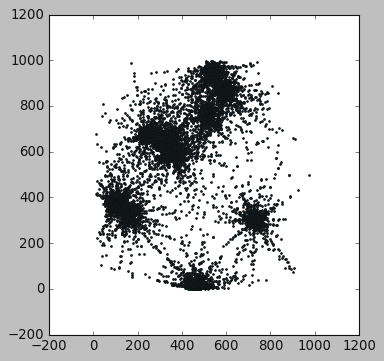

In [9]:
plt.style.use("classic")
plt.figure(figsize=(5, 5))
plt.scatter(df2_Epi['x'], df2_Epi['y'], s=2, cmap='rainbow')
plt.show()

In [10]:
# For Prophet node locations
fileName2_Pro = ('/Users/allenwang/Desktop/Columbia/E6772_Machine_Networking/Project/ML-Classification-DTN-Routing-main/data/prophet_NodeLocs.xlsx')
df2_Pro = pd.read_excel(fileName2_Pro)
print('Prophet Node Location Dataset size: ', df2_Pro.shape)
df2_Pro.head()

Prophet Node Location Dataset size:  (22400, 4)


,time,node,x,y
0,25,p0,359.2952,593.5965
1,25,p1,595.1697,864.0757
2,25,p2,150.4684,323.1847
3,25,p3,246.6003,679.0803
4,25,p4,99.0202,383.6092


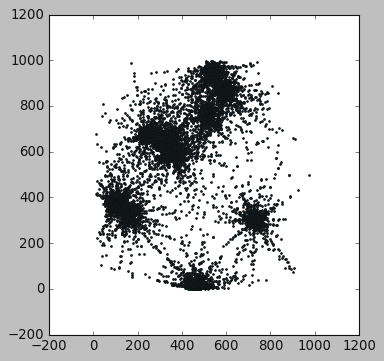

In [11]:
plt.style.use("classic")
plt.figure(figsize=(5, 5))
plt.scatter(df2_Pro['x'], df2_Pro['y'], s=2, cmap='rainbow')
plt.show()

#### As can be seen, the node locations for the two datasets are identical. The only difference till now is the routing protocol.\
#### For simplicity, we only keep one node location file for the following tasks

In [12]:
# Unified the dataframe for node locations
df2 = df2_Pro

### 4. Determining optimal value of K in K Means Clustering

==================================================

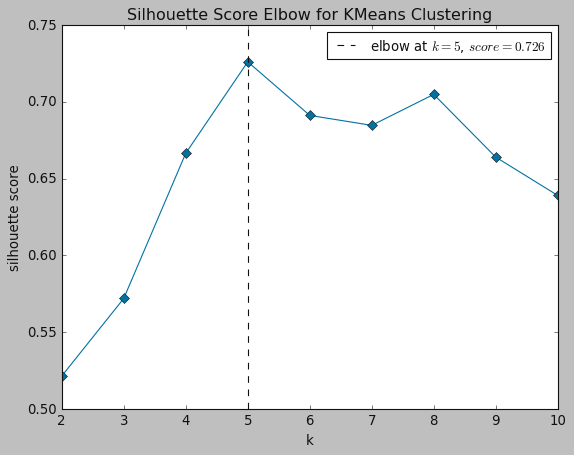

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [13]:
# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)  # Create a KMeans model with a fixed random state for reproducibility

# Instantiate the KElbowVisualizer with the number of clusters and the metric
visualizer = KElbowVisualizer(
    model,  # K-Means model to be used
    k=(2, num_nodes + 1),  # Range of k values to test. Assuming num_nodes is the upper limit for k.
    metric='silhouette',  # Silhouette score used to evaluate cluster quality
    timings=False  # Disables timing of k-means fitting process
)

# Prepare data for clustering
data = df2[['x', 'y']]  # Extracts only the x and y columns from df2 for clustering

# Fit the K-Means model to the data and visualize the elbow curve to find the optimal number of clusters
visualizer.fit(data)  # Fits the K-Means model to the data and computes the silhouette scores for each k
visualizer.poof()  # Displays the elbow plot which helps to determine the optimal k by looking where the elbow occurs

#### As can be seen here, the optimal value for $k$ should be 5 based on the Silhouette Score Elbow results. Therefore, for the following tasks, we clustered all the nodes into 5 clusters.

#### It is worth noting that the kmeans algorithm is run for ten times with different initial centroids for finding better clustering results

In [14]:
# Initialize the KMeans clustering model with specified parameters
kmeans = KMeans(
    n_clusters=5,         # Number of clusters to form
    init='k-means++',     # Initialization method for centroids
    n_init=num_nodes      # Number of time the k-means algorithm will run with different centroid seeds
)
data = df2[['x', 'y']]  # Select the columns for clustering
kmeans.fit(data)        # Fit the KMeans model on the data

# Clean and convert 'node' column values from strings to integers
df2["node"] = df2["node"].str.replace("p", "")  # Remove 'p' from 'node' column strings
df2['node'] = df2['node'].astype(int)           # Convert 'node' column to integer type

# Assign cluster labels to each data point based on their x, y coordinates
df2['cluster_label'] = kmeans.fit_predict(df2[df2.columns[2:4]])  # Compute cluster labels for each point

df2  # Display the updated DataFrame

,time,node,x,y,cluster_label
0,25,0,359.2952,593.5965,2
1,25,1,595.1697,864.0757,0
2,25,2,150.4684,323.1847,1
3,25,3,246.6003,679.0803,2
4,25,4,99.0202,383.6092,1
...,...,...,...,...,...
22395,56000,5,511.8530,720.8290,0
22396,56000,6,343.5899,643.3298,2
22397,56000,7,531.3970,956.0542,0
22398,56000,8,744.8229,294.0880,3


In [15]:
# Calculate the average cluster label for each node and round it to the nearest integer
temp = [
    [i, round(df2[df2['node'] == i]['cluster_label'].mean())]  # Compute mean cluster label for each node and round
    for i in range(num_nodes)  # Iterate over each node
]

# Create a new DataFrame from the computed averages
df3 = pd.DataFrame(temp, columns=['node', 'region'])  # Assign column names 'node' and 'region'

df3  # Display the DataFrame

,node,region
0,0,2
1,1,0
2,2,1
3,3,2
4,4,1
5,5,0
6,6,2
7,7,0
8,8,3
9,9,4


As can be seen, there are only 5 regions, which corresponds to the selection of K as 5

### 5. Plotting the Node Clusters

==================================================

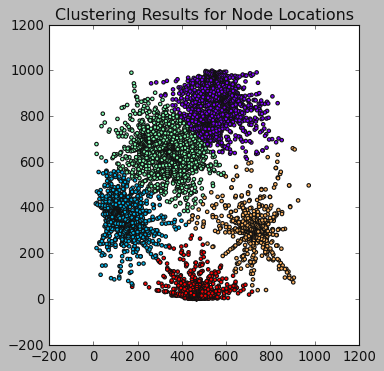

In [16]:
plt.figure(figsize=(5, 5))
plt.scatter(data['x'], data['y'], c=kmeans.labels_, cmap='rainbow', s=10)
plt.title("Clustering Results for Node Locations")
plt.show()

### 6. Merge the Regional Features with the Original Dataframe for Epidemic and Prophet Datasets

==================================================

In [17]:
# For Epidemic
# Merging the two databases to create region code features
df_Epi = pd.merge(df_Epi, df3, left_on="fromHost", right_on="node")  
# Merge df with df3 to add region information for 'fromHost'. df3 contains node-to-region mapping.

df_Epi = pd.merge(df_Epi, df3, left_on="toHost", right_on="node")  
# Further merge the updated df with df3 to add region information for 'toHost'.

df_Epi = df_Epi.drop(['node_x', 'node_y'], axis=1)  
# Remove the 'node_x' and 'node_y' columns from df after merging, as they are redundant.

df_Epi['deliveryStatus'] = df_Epi.apply(lambda row: row['toHost'] in row['path'], axis=1)  
# Add a new column 'deliveryStatus' to df. This column is True if 'toHost' is in the 'path' list of the row,
# indicating successful delivery, and False otherwise.

df_Epi  # Display the updated DataFrame

,ID,epoch_index,fromHost,toHost,path,region_x,region_y,deliveryStatus
0,1,0,6,1,"{6, 0}",2,0,False
1,1,3,6,1,"{3, 6}",2,0,False
2,1,4,6,1,"{5, 7, 6, 0}",2,0,False
3,1,5,6,1,"{6, 5, 0, 7, 1}",2,0,False
4,1,8,6,1,"{4, 3, 6, 2}",2,0,False
...,...,...,...,...,...,...,...,...
3997,77,22,2,6,"{2, 8, 0}",1,2,False
3998,77,27,2,6,"{2, 0, 1}",1,2,False
3999,77,29,2,6,"{7, 2, 0, 1}",1,2,False
4000,77,30,2,6,"{2, 0, 3, 9}",1,2,False


In [18]:
# For Prophet
# Merging the two databases to create region code features
df_Pro = pd.merge(df_Pro, df3, left_on="fromHost", right_on="node")  
# Merge df with df3 to add region information for 'fromHost'. df3 contains node-to-region mapping.

df_Pro = pd.merge(df_Pro, df3, left_on="toHost", right_on="node")  
# Further merge the updated df with df3 to add region information for 'toHost'.

df_Pro = df_Pro.drop(['node_x', 'node_y'], axis=1)  
# Remove the 'node_x' and 'node_y' columns from df after merging, as they are redundant.

df_Pro['deliveryStatus'] = df_Pro.apply(lambda row: row['toHost'] in row['path'], axis=1)  
# Add a new column 'deliveryStatus' to df. This column is True if 'toHost' is in the 'path' list of the row,
# indicating successful delivery, and False otherwise.

df_Pro  # Display the updated DataFrame

,ID,epoch_index,fromHost,toHost,path,region_x,region_y,deliveryStatus
0,1,4,6,1,"{5, 7, 6, 0}",2,0,False
1,1,5,6,1,"{7, 6, 0, 1}",2,0,False
2,1,11,6,1,"{3, 6}",2,0,False
3,1,22,6,1,"{3, 6, 8}",2,0,False
4,1,36,6,1,"{4, 3, 6, 8}",2,0,False
...,...,...,...,...,...,...,...,...
2762,77,22,2,6,"{2, 8, 0, 3}",1,2,False
2763,77,23,2,6,"{4, 2}",1,2,False
2764,77,65,2,6,"{5, 2, 0}",1,2,False
2765,77,90,2,6,"{2, 0, 9}",1,2,False


### 7. Processing for Feature Sets and Target Variable Sets

==================================================

#### For Epidemic Dataset

In [19]:
# Generating the labels (r0-r9)
for x in range(num_nodes):
    label = 'r' + str(x)
    df_Epi[label] = df_Epi.apply(lambda row: str(x) in row['path'], axis=1)

df_Epi.drop(['ID'], axis=1, inplace=True)
df_Epi.drop(['path'], axis=1, inplace=True)
df_Epi

,epoch_index,fromHost,toHost,region_x,region_y,deliveryStatus,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,0,6,1,2,0,False,True,False,False,False,False,False,True,False,False,False
1,3,6,1,2,0,False,False,False,False,True,False,False,True,False,False,False
2,4,6,1,2,0,False,True,False,False,False,False,True,True,True,False,False
3,5,6,1,2,0,False,True,True,False,False,False,True,True,True,False,False
4,8,6,1,2,0,False,False,False,True,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3997,22,2,6,1,2,False,True,False,True,False,False,False,False,False,True,False
3998,27,2,6,1,2,False,True,True,True,False,False,False,False,False,False,False
3999,29,2,6,1,2,False,True,True,True,False,False,False,False,True,False,False
4000,30,2,6,1,2,False,True,False,True,True,False,False,False,False,False,True


In [20]:
X_Epi = df_Epi[df_Epi.columns[:6]][:]
y_Epi = df_Epi[df_Epi.columns[6:]]
print(X_Epi.shape)
print(y_Epi.shape)

(4002, 6)
(4002, 10)


#### For Prophet Dataset

In [21]:
# Generating the labels (r0-r9)
for x in range(num_nodes):
    label = 'r' + str(x)
    df_Pro[label] = df_Pro.apply(lambda row: str(x) in row['path'], axis=1)

df_Pro.drop(['ID'], axis=1, inplace=True)
df_Pro.drop(['path'], axis=1, inplace=True)
df_Pro

,epoch_index,fromHost,toHost,region_x,region_y,deliveryStatus,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9
0,4,6,1,2,0,False,True,False,False,False,False,True,True,True,False,False
1,5,6,1,2,0,False,True,True,False,False,False,False,True,True,False,False
2,11,6,1,2,0,False,False,False,False,True,False,False,True,False,False,False
3,22,6,1,2,0,False,False,False,False,True,False,False,True,False,True,False
4,36,6,1,2,0,False,False,False,False,True,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2762,22,2,6,1,2,False,True,False,True,True,False,False,False,False,True,False
2763,23,2,6,1,2,False,False,False,True,False,True,False,False,False,False,False
2764,65,2,6,1,2,False,True,False,True,False,False,True,False,False,False,False
2765,90,2,6,1,2,False,True,False,True,False,False,False,False,False,False,True


In [22]:
X_Pro = df_Pro[df_Pro.columns[:6]][:]
y_Pro = df_Pro[df_Pro.columns[6:]]
print(X_Pro.shape)
print(y_Pro.shape)

(2767, 6)
(2767, 10)


### 8. Dividing into Train and Test Splits

==================================================

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
# For Epidemic Dataset
X_train_Epi, X_test_Epi, y_train_Epi, y_test_Epi = train_test_split(X_Epi,
                                                    y_Epi,
                                                    test_size=0.2,
                                                    random_state=seed)
print(X_train_Epi.shape, y_train_Epi.shape)
print(X_test_Epi.shape, y_test_Epi.shape)

(3201, 6) (3201, 10)
(801, 6) (801, 10)


In [25]:
# For Prophet Dataset
X_train_Pro, X_test_Pro, y_train_Pro, y_test_Pro = train_test_split(X_Pro,
                                                    y_Pro,
                                                    test_size=0.2,
                                                    random_state=seed)
print(X_train_Pro.shape, y_train_Pro.shape)
print(X_test_Pro.shape, y_test_Pro.shape)

(2213, 6) (2213, 10)
(554, 6) (554, 10)


In [26]:
# Scaling the data
# For Epidemic
sc_x = StandardScaler()
X_train_Epi = sc_x.fit_transform(X_train_Epi)
X_test_Epi = sc_x.transform(X_test_Epi)

# For Prophet
sc_x = StandardScaler()
X_train_Pro = sc_x.fit_transform(X_train_Pro)
X_test_Pro = sc_x.transform(X_test_Pro)

### 9. Machine Learning: Classifiers, Metrics, and Multi-label Models Definitions

==================================================

In [27]:
# Multi-label Models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset

# Classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics
from sklearn.metrics import jaccard_score, hamming_loss, zero_one_loss, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import classification_report

# Statistics
from statistics import mean

In [28]:
# Classifiers
classifiers = [
    DecisionTreeClassifier(),
    GaussianNB(),
    KNeighborsClassifier(n_neighbors=1)
]

# Titles
titles = [
    "Epidemic - Decision Tree",
    "Epidemic - Naive Bayes",
    "Epidemic - KNN",
    "PRoPHET - Decision Tree",
    "PRoPHET - Naive Bayes",
    "PRoPHET - KNN"
]

# Evaluation metrics and multi-label models
metrics = ['jaccard', 'hamming', 'zero_one', 'f1']
model_names = ('Independent', 'Chain(Averaged)', 'Ensemble', 'Label Powerset')

In [29]:
# Initialize dictionaries to store all
# the metrics for each multi-label model
metric_jaccard_results = {
    'indep_results': [],
    'chain_av_results': [],
    'ensemble_results': [],
    'powerset_results': []
}
metric_hamming_results = {
    'indep_results': [],
    'chain_av_results': [],
    'ensemble_results': [],
    'powerset_results': []
}
metric_zero_one_results = {
    'indep_results': [],
    'chain_av_results': [],
    'ensemble_results': [],
    'powerset_results': []
}
metric_f1_results = {
    'indep_results': [],
    'chain_av_results': [],
    'ensemble_results': [],
    'powerset_results': []
}

### 10. Training the Multi-Label Models for the Two Protocols under the Four Evaluation Metrics

==================================================

At this step, we also output the classification reports

In [30]:
j = 0
# Define protocols and their corresponding datasets for classification
datasets = {
    'Epidemic': (X_train_Epi, X_test_Epi, y_train_Epi, y_test_Epi),
    'Prophet': (X_train_Pro, X_test_Pro, y_train_Pro, y_test_Pro)
}

# Initialize dictionaries to store metrics results for different models within each protocol
metrics = ['jaccard', 'hamming', 'zero_one', 'f1']
results = {protocol: {metric: {'Independent': [], 'Chain': [], 'Ensemble': [], 'Label Powerset': []} 
           for metric in metrics} for protocol in datasets}

# Initialize a dictionary to store the classification reports if needed
classification_reports = {
    protocol: {model: [] for model in ['Independent', 'Chain', 'Ensemble', 'Label Powerset']}
    for protocol in datasets
}

# Process each protocol's data
for protocol, (X_train, X_test, y_train, y_test) in datasets.items():
    for j, base_lr in enumerate(classifiers):
        #---------------------------------------------------------------------------------
        #---------------------------------------------------------------------------------
        
        # Independent model using OneVsRestClassifier
        ovr = OneVsRestClassifier(base_lr)
        ovr.fit(X_train, y_train)
        Y_pred_ovr = ovr.predict(X_test)
        # Store or print classification report
        report_ovr = classification_report(y_test, Y_pred_ovr)
        print(f"Classifier {classifiers[j].__class__.__name__}'s Classification Report for Independent ({protocol}): \n{report_ovr}")        
        classification_reports[protocol]['Independent'].append(report_ovr)


        # Calculate metrics for the Independent model
        ovr_jaccard_score = jaccard_score(y_test, Y_pred_ovr, average='samples')
        ovr_hamming_score = hamming_loss(y_test, Y_pred_ovr)
        ovr_f1_score = precision_recall_fscore_support(y_test, Y_pred_ovr, average='micro')[2]
        ovr_zero_one_score = zero_one_loss(y_test, Y_pred_ovr, normalize=True)
        
        #---------------------------------------------------------------------------------
        #---------------------------------------------------------------------------------
        
        # Classifier Chains: create and fit an ensemble of classifier chains
        chains = [ClassifierChain(base_lr, order='random', random_state=i) for i in range(10)]
        for chain in chains:
            chain.fit(X_train, y_train)

        # Predict using chains and calculate average predictions
        Y_pred_chains = np.array([chain.predict(X_test) for chain in chains])
        chain_jaccard_scores = [jaccard_score(y_test, Y_pred_chain >= .5, average='samples') for Y_pred_chain in Y_pred_chains]
        chain_hamming_scores = [hamming_loss(y_test, Y_pred_chain >= .5) for Y_pred_chain in Y_pred_chains]
        chain_f1_scores = [precision_recall_fscore_support(y_test, Y_pred_chain >= .5, average='micro')[2] for Y_pred_chain in Y_pred_chains]
        chain_zero_one_scores = [zero_one_loss(y_test, Y_pred_chain >= .5) for Y_pred_chain in Y_pred_chains]

        # Store or print classification report and Calculate average scores for chains
        # Average the predictions across the ensemble of chains
        # Convert probabilities to binary output using thresholding
        Y_pred_chain_avg = (Y_pred_chains.mean(axis=0) >= 0.5).astype(int)
        report_chain_avg = classification_report(y_test, Y_pred_chain_avg)
        
        # Print or store the classification report for the averaged chain model
        print(f"Classifier {classifiers[j].__class__.__name__}'s Classification Report for Chain Averaged ({protocol}): \n{report_chain_avg}")
        classification_reports[protocol]['Chain'].append(report_chain_avg)
        
        chain_jaccard_av = mean(chain_jaccard_scores)
        chain_hamming_av = mean(chain_hamming_scores)
        chain_f1_av = mean(chain_f1_scores)
        chain_zero_one_av = mean(chain_zero_one_scores)
        
        #---------------------------------------------------------------------------------
        #---------------------------------------------------------------------------------
        
        # Ensemble Classifier: aggregate predictions from chains
        Y_pred_ensemble = (Y_pred_chains.mean(axis=0) >= 0.5).astype(int)
        # Store or print classification report
        report_ensemble = classification_report(y_test, Y_pred_ensemble)
        print(f"Classifier {classifiers[j].__class__.__name__}'s Classification Report for Ensemble ({protocol}): \n{report_ensemble}")
        classification_reports[protocol]['Ensemble'].append(report_ensemble)
        
        # Calculate metrics for the Ensemble Classifier model
        ensemble_jaccard_score = jaccard_score(y_test, Y_pred_ensemble >= .5, average='samples')
        ensemble_hamming_score = hamming_loss(y_test, Y_pred_ensemble >= .5)
        ensemble_f1_score = precision_recall_fscore_support(y_test, Y_pred_ensemble >= .5, average='micro')[2]
        ensemble_zero_one_score = zero_one_loss(y_test, Y_pred_ensemble >= .5)
        
        #---------------------------------------------------------------------------------
        #---------------------------------------------------------------------------------
        
        # Label Powerset model
        lp = LabelPowerset(base_lr)
        Y_pred_lp = lp.fit(X_train, y_train).predict(X_test)
        # Store or print classification report
        report_lp = classification_report(y_test, Y_pred_lp)
        print(f"Classifier {classifiers[j].__class__.__name__}'s Classification Report for Label Powerset ({protocol}): \n{report_lp}")
        classification_reports[protocol]['Label Powerset'].append(report_lp)
        
        # Calculate metrics for the Label Powerset model
        powerset_jaccard_score = jaccard_score(y_test, Y_pred_lp, average='samples')
        powerset_hamming_score = hamming_loss(y_test, Y_pred_lp)
        powerset_f1_score = precision_recall_fscore_support(y_test, Y_pred_lp, average='micro')[2]
        powerset_zero_one_score = accuracy_score(y_test, Y_pred_lp)

        # Store results in the global metrics dictionaries
        for metric in metrics:
            globals()['metric_{}_results'.format(metric)]['indep_results'].append(globals()['ovr_{}_score'.format(metric)])
            globals()['metric_{}_results'.format(metric)]['chain_av_results'].append(globals()['chain_{}_av'.format(metric)])
            globals()['metric_{}_results'.format(metric)]['ensemble_results'].append(globals()['ensemble_{}_score'.format(metric)])
            globals()['metric_{}_results'.format(metric)]['powerset_results'].append(globals()['powerset_{}_score'.format(metric)])

        j += 1  # Increment index for classifiers


Classifier DecisionTreeClassifier's Classification Report for Independent (Epidemic): 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       432
           1       0.90      0.85      0.88       319
           2       0.90      0.91      0.90       267
           3       0.86      0.89      0.87       351
           4       0.92      0.91      0.91       250
           5       0.89      0.86      0.87       407
           6       0.89      0.92      0.90       523
           7       0.94      0.85      0.89       212
           8       0.96      0.88      0.92        60
           9       0.93      0.97      0.95       175

   micro avg       0.90      0.89      0.89      2996
   macro avg       0.91      0.89      0.90      2996
weighted avg       0.90      0.89      0.89      2996
 samples avg       0.91      0.89      0.88      2996

Classifier DecisionTreeClassifier's Classification Report for Chain Averaged (Epidemic): 
          

Classifier DecisionTreeClassifier's Classification Report for Chain Averaged (Prophet): 
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       252
           1       0.92      0.87      0.90       166
           2       0.97      0.95      0.96       151
           3       0.91      0.91      0.91       199
           4       0.94      0.96      0.95       160
           5       0.90      0.96      0.93       216
           6       0.92      0.89      0.90       257
           7       0.98      0.96      0.97       125
           8       0.91      0.99      0.94        69
           9       0.98      1.00      0.99        54

   micro avg       0.93      0.93      0.93      1649
   macro avg       0.94      0.94      0.94      1649
weighted avg       0.93      0.93      0.93      1649
 samples avg       0.94      0.94      0.93      1649

Classifier DecisionTreeClassifier's Classification Report for Ensemble (Prophet): 
              p

/Users/allenwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allenwang/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classifier KNeighborsClassifier's Classification Report for Independent (Prophet): 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       252
           1       0.90      0.84      0.87       166
           2       0.92      0.94      0.93       151
           3       0.82      0.87      0.84       199
           4       0.88      0.91      0.90       160
           5       0.89      0.92      0.90       216
           6       0.87      0.81      0.83       257
           7       0.92      0.95      0.94       125
           8       0.86      0.90      0.88        69
           9       0.88      0.96      0.92        54

   micro avg       0.88      0.88      0.88      1649
   macro avg       0.88      0.89      0.89      1649
weighted avg       0.88      0.88      0.88      1649
 samples avg       0.89      0.89      0.88      1649

Classifier KNeighborsClassifier's Classification Report for Chain Averaged (Prophet): 
              pr

### 11. Preparation for Plotting

==================================================

In [31]:
# Define headers for each subplot in the visualization, corresponding to different evaluation metrics.
# These headers will be used as titles for individual subplots in the charts.
headers = [
    'Jaccard Similarity Score for ZebraNet UTM1 Dataset',
    'Hamming Loss for ZebraNet UTM1 Dataset',
    'Zero-One Loss for ZebraNet UTM1 Dataset',
    'Micro-Averaged F1 Score for ZebraNet UTM1 Dataset'
]

def wrap_titles(titles):
    new_titles = []
    for title in titles:
        # Append \n before the () symbol
        pos = title.find('(')
        if pos != -1:
            title = title[:pos] + '\n' + title[pos:]
        new_titles.append(title)
    return new_titles

# Apply the wrap function
titles = wrap_titles([
    "D-tree (Epidemic)",
    "Gaussian-NB (Epidemic)", 
    "KNN (Epidemic)",
    "D-tree (PRoPHET)", 
    "Gaussian-NB (PRoPHET)",
    "KNN (PRoPHET)"
])

In [32]:
# Check whether title length is aligned
print("Titles length:", len(titles))
for metric in metrics:
    indep_len = len(globals()['metric_{}_results'.format(metric)]['indep_results'])
    chain_av_len = len(globals()['metric_{}_results'.format(metric)]['chain_av_results'])
    ensemble_len = len(globals()['metric_{}_results'.format(metric)]['ensemble_results'])
    powerset_len = len(globals()['metric_{}_results'.format(metric)]['powerset_results'])
    print(f"{metric} - Independent: {indep_len}, Chain: {chain_av_len}, Ensemble: {ensemble_len}, Powerset: {powerset_len}")


Titles length: 6
jaccard - Independent: 6, Chain: 6, Ensemble: 6, Powerset: 6
hamming - Independent: 6, Chain: 6, Ensemble: 6, Powerset: 6
zero_one - Independent: 6, Chain: 6, Ensemble: 6, Powerset: 6
f1 - Independent: 6, Chain: 6, Ensemble: 6, Powerset: 6


### 12. Results

==================================================

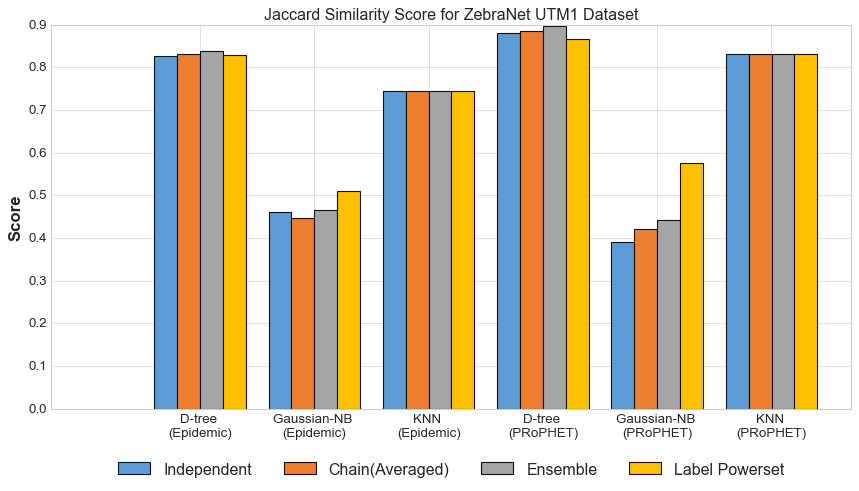

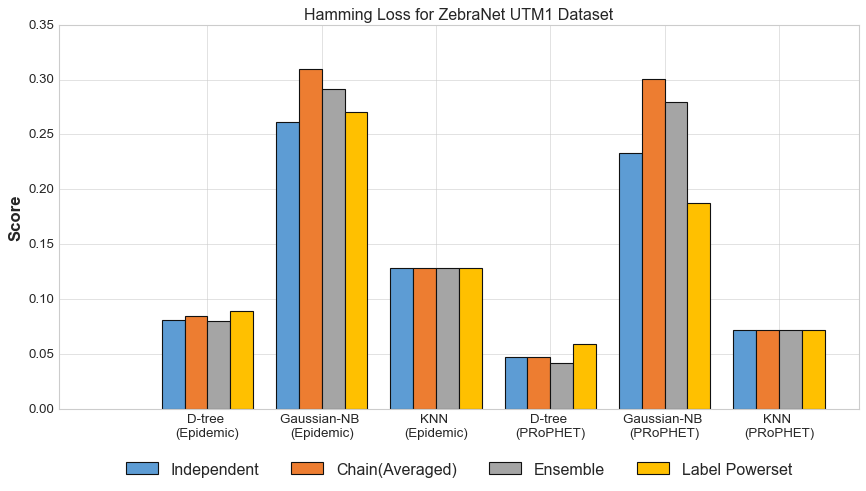

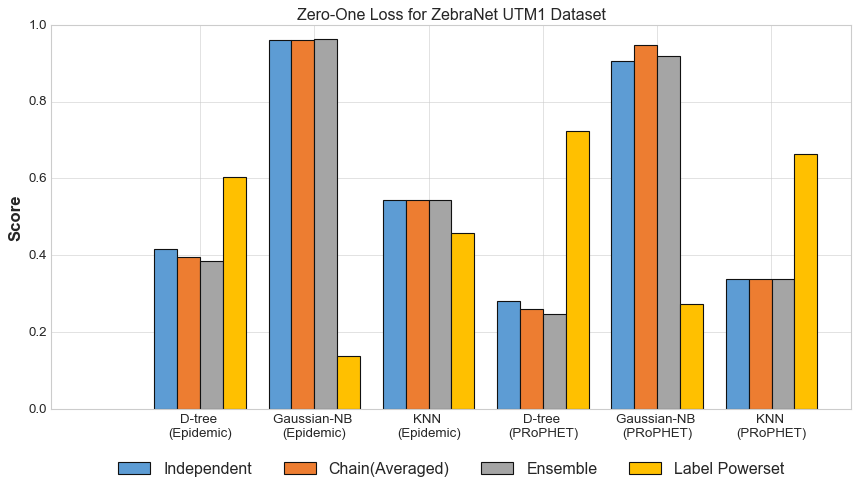

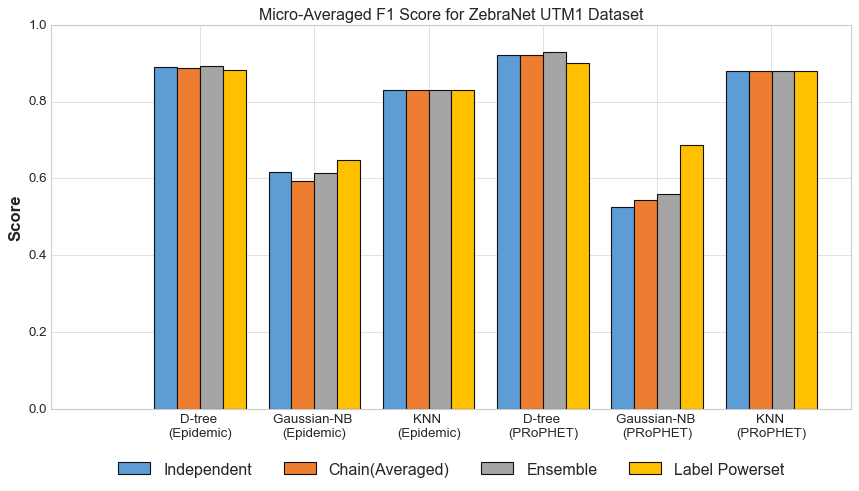

In [33]:
# Initialize the plot style to a clean grid background
plt.style.use("seaborn-whitegrid")

# Initialize an iterator to track the index for headers
itr = 0

# Loop through each metric defined previously to create separate plots
for metric in metrics:
    # Define the width of each bar in the bar plot
    barWidth = 0.2
    
    # Create a new figure and axes for plotting
    fig, ax = plt.subplots(figsize=(25, 6))
    
    # Enable grid for better readability of the plot
    ax.grid(True)
    
    # Set the title of the current subplot using the headers list
    ax.set_title(headers[itr])

    # Calculate the positions of groups of bars on the X-axis
    br1 = np.arange(len(titles))
    br2 = [x + barWidth for x in br1]
    br3 = [x + barWidth for x in br2]
    br4 = [x + barWidth for x in br3]

    # Plot bars for each model type with distinct colors and labels
    plt.bar(br1, globals()['metric_{}_results'.format(metric)]['indep_results'], color='#5d9cd4', width=barWidth, label='Independent')
    plt.bar(br2, globals()['metric_{}_results'.format(metric)]['chain_av_results'], color='#ed7d31', width=barWidth, label='Chain(Averaged)')
    plt.bar(br3, globals()['metric_{}_results'.format(metric)]['ensemble_results'], color='#a5a5a5', width=barWidth, label='Ensemble')
    plt.bar(br4, globals()['metric_{}_results'.format(metric)]['powerset_results'], color='#ffc000', width=barWidth, label='Label Powerset')

    plt.ylabel('Score', fontweight='bold', fontsize=15)
    # Adjust X-ticks to be in the center of the groups of bars and rotate labels for better visibility
    plt.xticks([r + 1.5 * barWidth for r in range(len(titles))], titles, ha='center')
    
    # Add a legend to the plot, positioned below the chart to avoid overlap with the bars
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=5)
    
    plt.subplots_adjust(left=0.3, right=0.7)
    
    plt.savefig(f'{metric}.jpg')
    plt.show()
    
    itr += 1

# Increment the count of iterations (presumably for tracking how many times the plots are generated)
iterations = iterations + 1
